# Mini Project 1 Plant Pathology: 
### WeiWei Liu; Yuening Li
In this project, we will build and train  a convolutional neural network (CNN) for classification of the foliage diseases in apple trees based on leaf images from Kaggle Plant Pathology 2020 challenge at (https://www.kaggle.com/c/plant-pathology-2020-fgvc7). 

It use training data set (1820 apple trees leaves image) to classify the given images from testing data set (1820 apple trees leaves image) into categories include "healthy", "scab", "rust", and "multiple diseases". 

## Enabling and testing the TPU

As training the CNN model time consuming. We train our model on TPU for outstanding performance.

Let's check that we can connect to the TPU:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0-rc3
Running on TPU  ['10.26.222.202:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.26.222.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.26.222.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)




First, let's install dependencies, and import the relevant packages we'll need for this project.

In [0]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow as tf 

#!pip install mitdeeplearning
# import mitdeeplearning as mdl
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
# assert len(tf.config.list_physical_devices('GPU')) > 0

## 1.1 Dataset 

Then, fetch Datasets csv files from google drive into Google Colab

In [3]:
# mount google drive to colab
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
import pandas as pd
ROOT_PATH ='/content/gdrive/My Drive/Kaggle/plant-pathology-2020-fgvc7'
IMAGE_PATH = ROOT_PATH + "/images/"
TEST_PATH = ROOT_PATH + "/test.csv"
TRAIN_PATH = ROOT_PATH + "/train.csv"
SUB_PATH = ROOT_PATH + "/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

We stored our images data in TFRecord files

Use tf.data.experimental.AUTOTUNE to optimize different parts of images loading.

In [0]:
import os
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [512, 512]

batch_size = 16 * tpu_strategy.num_replicas_in_sync

gcs_pattern = 'gs://kds-44c8a6f93070fa89189427ff10c4c0530ab3f532ac92907ab3c2bb58'

def format_path(image_id):
    return gcs_pattern + "/images/"+image_id + ".jpg"
    
test_paths = test_data.image_id.apply(format_path).values
train_paths = train_data.image_id.apply(format_path).values
train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)

from sklearn.model_selection import train_test_split
# split the training set path into two set of training path and valid/testing set path 
# in propportion of 0.85:0.15
train_paths, valid_paths, train_labels, test_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

Load training set and split it to two set of training and valid set(test set).

In [0]:
def load_image(img_path,label=None):
    bits = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (512, 512))
    if label is None:
      return image
    else:
      return image, label

In [9]:
tqdm.pandas()
TRAIN_LEN = len(train_paths)
TEST_LEN = len(valid_paths)
# read in the giving training set
train_images = pd.DataFrame(data=train_paths)[0][:TRAIN_LEN].progress_apply(load_image)
test_images =pd.DataFrame(data=valid_paths)[0][:TEST_LEN].progress_apply(load_image)

100%|██████████| 274/274 [00:13<00:00, 19.72it/s]


Our training set is made up of 1547 images of apple tree leaves images.

Our valid/testing set is made up of 273 images of apple tree leaves images.

## 1.2 Visualize 
Let's visulaize some of images from training set and their corresponding training labels.

[1,0,0,0] correspond to "healthy" leaf which are green

[0,1,0,0] correspond to "scab" leaf which has brown marks on it which indicate bactaria/fungal infection

[0,0,1,0] correspond to "rust" leaf which has yellow mark on it, which indicate a specific kind of rust fungi

[0,0,0,1] correspond to "multiple diseases" leaf

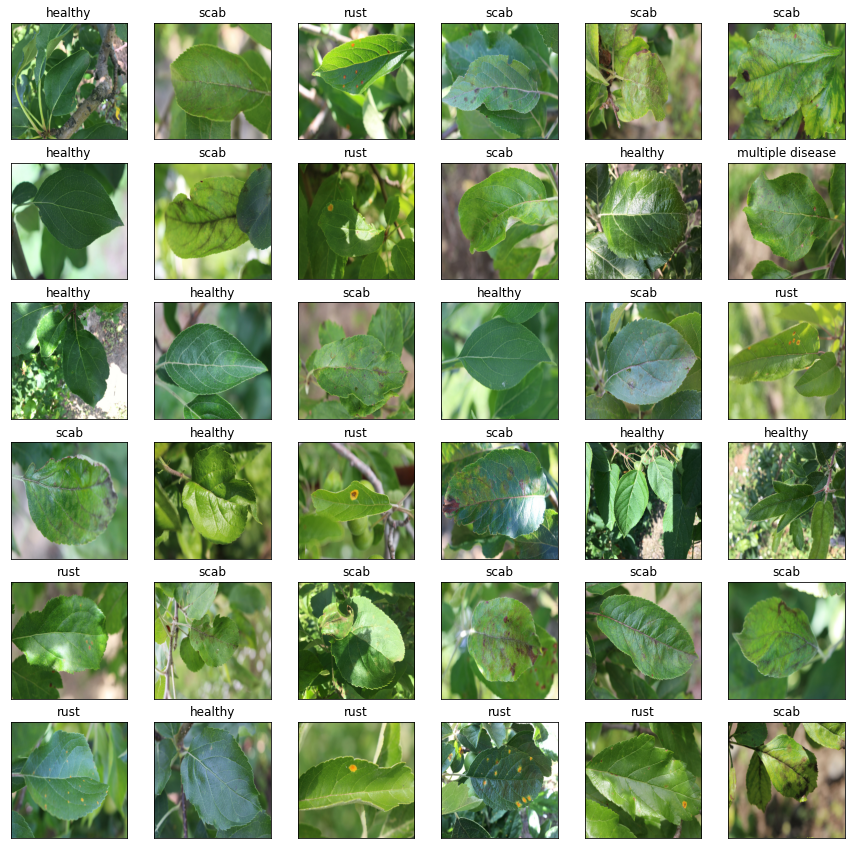

In [39]:
plt.figure(figsize=(15,15))
dic = dict([(0,'healthy'),(2,"rust"),(3,"scab"),(1,"multiple disease")])
random_inds = np.random.choice(1547,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    key = np.argmax(train_labels[image_ind]) 
    plt.title(dic[key])

Combine Training images with Training Labels; and valid images with Testing labels into format of Dataset

In [0]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(load_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(512)
    .repeat()
    .batch(batch_size)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, test_labels))
    .map(load_image, num_parallel_calls=AUTO)
    .batch(batch_size)
    .prefetch(AUTO)
)

## 1.2 Convolutional Neural Network (CNN) for foliage diseases classification

Firstly We build the CNN model `build_cnn_model_1` using the lab code. But Achieving a accuracy around 0.34.

To maximize accuracy, we build `build_cnn_model`. It leverage a pretrained image recognition model (here, DenseNet121),and add a max pooling and a softmax layer to predict our 4 classes.


### Define the CNN model

Now, we use the training and test dataset to define and train our new CNN model.  

In [0]:
def build_cnn_model_1():
    cnn_model = tf.keras.Sequential([

        # TODO: Define the first convolutional layer
        tf.keras.layers.Conv2D(filters=24,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(512, 512, 3), activation='relu'), 

        # TODO: Define the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2)),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D(filters=36,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2)),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # TODO: Define the last Dense layer to output the classification 
        # probabilities. Pay attention to the activation needed a probability
        # output
        
        tf.keras.layers.Dense(4,activation='softmax')
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model_1()

In [17]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
                                     
        tf.keras.applications.DenseNet121(input_shape=(512, 512, 3),weights='imagenet',include_top=False),
        
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(4,activation='softmax')
    ])

    cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy']) 
    
    return cnn_model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and metrics through the `compile` method. Compile the CNN model with an Adam optimizer with loss function of `categorical_crossentropy`

In [0]:
# tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
# tf.keras.optimizers.Adagrad(learning_rate=1e-1)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy']) 

Then we can train our CNN using the `fit` method via the Keras API.

In [19]:
EPOCHS = 20
n_train = len(train_paths)
n_valid = len(valid_paths)
train_steps = n_train // batch_size
history = cnn_model.fit(train_dataset, validation_data=valid_dataset,steps_per_epoch=train_steps, epochs=EPOCHS)

Epoch 1/20
12/12 [==============================] - 43s 4s/step - accuracy: 0.7826 - loss: 0.5591 - val_accuracy: 0.3321 - val_loss: 30.6110
Epoch 2/20
12/12 [==============================] - 19s 2s/step - accuracy: 0.9173 - loss: 0.2718 - val_accuracy: 0.3321 - val_loss: 24.5132
Epoch 3/20
12/12 [==============================] - 19s 2s/step - accuracy: 0.9421 - loss: 0.1809 - val_accuracy: 0.3321 - val_loss: 11.6196
Epoch 4/20
12/12 [==============================] - 20s 2s/step - accuracy: 0.9720 - loss: 0.0991 - val_accuracy: 0.3321 - val_loss: 5.5582
Epoch 5/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9701 - loss: 0.0891WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that re

12/12 [==============================] - 19s 2s/step - accuracy: 0.9701 - loss: 0.0891 - val_accuracy: 0.4234 - val_loss: 4.7110
Epoch 6/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9772 - loss: 0.0756WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9772 - loss: 0.0756 - val_accuracy: 0.5328 - val_loss: 5.9379
Epoch 7/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9870 - loss: 0.0475WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 20s 2s/step - accuracy: 0.9870 - loss: 0.0475 - val_accuracy: 0.8431 - val_loss: 1.0166
Epoch 8/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9818 - loss: 0.0610WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9818 - loss: 0.0610 - val_accuracy: 0.8832 - val_loss: 0.7221
Epoch 9/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9850 - loss: 0.0510WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9850 - loss: 0.0510 - val_accuracy: 0.8467 - val_loss: 2.0489
Epoch 10/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9863 - loss: 0.0437WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 21s 2s/step - accuracy: 0.9863 - loss: 0.0437 - val_accuracy: 0.7737 - val_loss: 1.4695
Epoch 11/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9909 - loss: 0.0371WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 21s 2s/step - accuracy: 0.9909 - loss: 0.0371 - val_accuracy: 0.6423 - val_loss: 1.2312
Epoch 12/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9805 - loss: 0.0569WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9805 - loss: 0.0569 - val_accuracy: 0.6241 - val_loss: 2.8163
Epoch 13/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9844 - loss: 0.0566WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9844 - loss: 0.0566 - val_accuracy: 0.7847 - val_loss: 1.1098
Epoch 14/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9824 - loss: 0.0452WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9824 - loss: 0.0452 - val_accuracy: 0.7993 - val_loss: 0.8987
Epoch 15/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9928 - loss: 0.0284WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9928 - loss: 0.0284 - val_accuracy: 0.4891 - val_loss: 1.9635
Epoch 16/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9967 - loss: 0.0185WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9967 - loss: 0.0185 - val_accuracy: 0.6314 - val_loss: 1.4340
Epoch 17/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9974 - loss: 0.0116WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 20s 2s/step - accuracy: 0.9974 - loss: 0.0116 - val_accuracy: 0.8942 - val_loss: 0.3773
Epoch 18/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9974 - loss: 0.0152WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9974 - loss: 0.0152 - val_accuracy: 0.8540 - val_loss: 0.4799
Epoch 19/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9928 - loss: 0.0275WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9928 - loss: 0.0275 - val_accuracy: 0.8321 - val_loss: 0.7627
Epoch 20/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9909 - loss: 0.0345WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8de37957b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9909 - loss: 0.0345 - val_accuracy: 0.8066 - val_loss: 0.5435


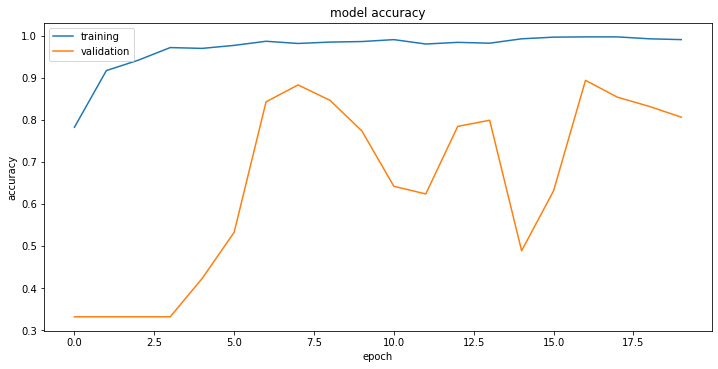

In [20]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)

Training accuracy goes up, but we observe fluctuation in the validation data accuracy.

To stabalize the validation data accuracy, we set up the Learning Rate Schedular to have learning rate change in each epoch.

Build LearningRateScheduler

Learning rate per epoch:


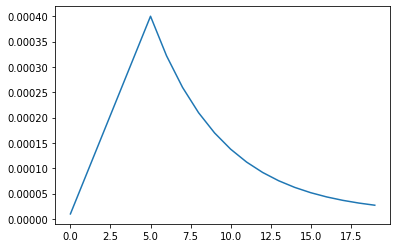

In [21]:
EPOCHS = 20

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

Rebuild CNN model

In [0]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
                                     
        tf.keras.applications.DenseNet121(input_shape=(512, 512, 3),weights='imagenet',include_top=False),
        
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(4,activation='softmax')
    ])

    cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy']) 
    
    return cnn_model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  cnn_model = build_cnn_model()

Re-Train the model with Learning Rate call back

In [23]:
history1 = cnn_model.fit(train_dataset, validation_data=valid_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS,callbacks=[lr_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
12/12 [==============================] - 42s 3s/step - accuracy: 0.1204 - loss: 1.5995 - val_accuracy: 0.1460 - val_loss: 1.6732 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 19s 2s/step - accuracy: 0.6641 - loss: 0.8790 - val_accuracy: 0.4453 - val_loss: 1.4067 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 19s 2s/step - accuracy: 0.8991 - loss: 0.3338 - val_accuracy: 0.5912 - val_loss: 1.0964 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 21s 2s/step - accuracy: 0.9479 - loss: 0.1594 - val_accuracy: 0.6387 - val_loss: 1.1035 - lr: 2.4400e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/20
12/12

12/12 [==============================] - 19s 2s/step - accuracy: 0.9837 - loss: 0.0678 - val_accuracy: 0.6934 - val_loss: 1.1491 - lr: 3.2200e-04

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9909 - loss: 0.0344WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9909 - loss: 0.0344 - val_accuracy: 0.7482 - val_loss: 0.7934 - lr: 4.0000e-04

Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9948 - loss: 0.0236WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9948 - loss: 0.0236 - val_accuracy: 0.8650 - val_loss: 0.4601 - lr: 3.2200e-04

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9974 - loss: 0.0172WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9974 - loss: 0.0172 - val_accuracy: 0.9015 - val_loss: 0.2669 - lr: 2.5960e-04

Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9974 - loss: 0.0136WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9974 - loss: 0.0136 - val_accuracy: 0.9343 - val_loss: 0.1889 - lr: 2.0968e-04

Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9967 - loss: 0.0174WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9967 - loss: 0.0174 - val_accuracy: 0.9343 - val_loss: 0.2305 - lr: 1.6974e-04

Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0106WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 20s 2s/step - accuracy: 0.9980 - loss: 0.0106 - val_accuracy: 0.9343 - val_loss: 0.2506 - lr: 1.3780e-04

Epoch 00012: LearningRateScheduler reducing learning rate to 0.00011223616000000004.
Epoch 12/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9980 - loss: 0.0088WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9980 - loss: 0.0088 - val_accuracy: 0.9343 - val_loss: 0.2067 - lr: 1.1224e-04

Epoch 00013: LearningRateScheduler reducing learning rate to 9.178892800000003e-05.
Epoch 13/20
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0053WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 21s 2s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9380 - val_loss: 0.1901 - lr: 9.1789e-05

Epoch 00014: LearningRateScheduler reducing learning rate to 7.543114240000003e-05.
Epoch 14/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9993 - loss: 0.0059WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9993 - loss: 0.0059 - val_accuracy: 0.9416 - val_loss: 0.1808 - lr: 7.5431e-05

Epoch 00015: LearningRateScheduler reducing learning rate to 6.234491392000002e-05.
Epoch 15/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0088WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9987 - loss: 0.0088 - val_accuracy: 0.9453 - val_loss: 0.1712 - lr: 6.2345e-05

Epoch 00016: LearningRateScheduler reducing learning rate to 5.1875931136000024e-05.
Epoch 16/20
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0041WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 21s 2s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9416 - val_loss: 0.1647 - lr: 5.1876e-05

Epoch 00017: LearningRateScheduler reducing learning rate to 4.3500744908800015e-05.
Epoch 17/20
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0047WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9489 - val_loss: 0.1460 - lr: 4.3501e-05

Epoch 00018: LearningRateScheduler reducing learning rate to 3.6800595927040014e-05.
Epoch 18/20
12/12 [==============================] - ETA: 0s - accuracy: 0.9987 - loss: 0.0066WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 0.9987 - loss: 0.0066 - val_accuracy: 0.9526 - val_loss: 0.1327 - lr: 3.6801e-05

Epoch 00019: LearningRateScheduler reducing learning rate to 3.1440476741632015e-05.
Epoch 19/20
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0037WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9526 - val_loss: 0.1262 - lr: 3.1440e-05

Epoch 00020: LearningRateScheduler reducing learning rate to 2.7152381393305616e-05.
Epoch 20/20
12/12 [==============================] - ETA: 0s - accuracy: 1.0000 - loss: 0.0046WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f8dadeead90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


12/12 [==============================] - 19s 2s/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9562 - val_loss: 0.1259 - lr: 2.7152e-05


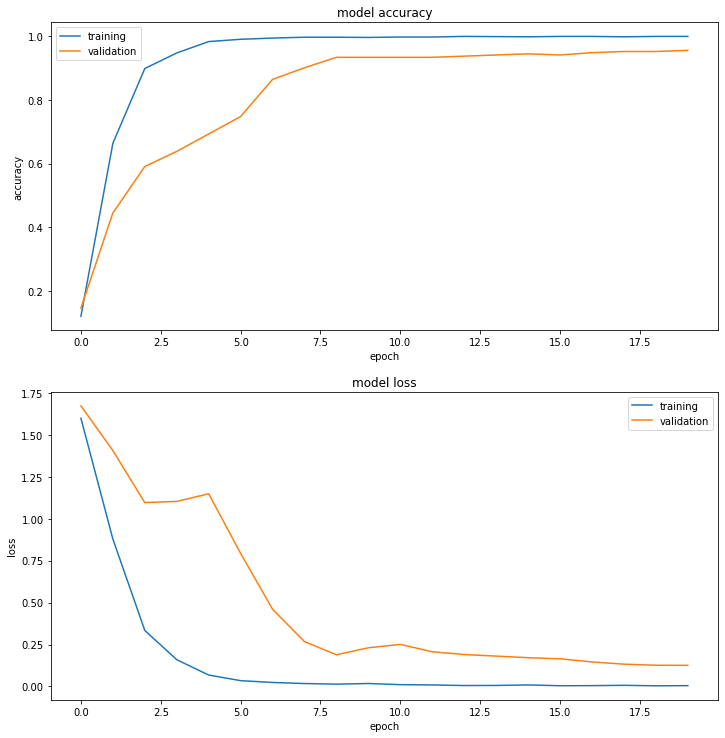

In [24]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history1.history['accuracy'], history1.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history1.history['loss'], history1.history['val_loss'], 'loss', 212)

Accuracy goes up and loss goes down. Looks good!

### Predictions 

With the model trained, we can use it to make predictions about our testing images. Here we only predict for 5 images of our test set


In [25]:
tqdm.pandas()
TEST_LEN = len(test_paths)
# read in the giving test set
test_images =pd.DataFrame(data=test_paths)[0][:5].progress_apply(load_image)

100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


In [0]:
test_images=tf.stack(test_images)
predictions = cnn_model.predict(test_images[0:6])

With this function call, the model has predicted the label for each of 5 images in the testing set. Let's take a look at the prediction:

In [27]:
'''0: 'healthy'; 1: 'multiple_diseases'; 2: 'rust'; 3: 'scab' '''
prediction =np.argmax(predictions,axis=1) 
print(prediction)

[2 2 3 0 2]


The predicted five images are in categories of :

 rust, rust, scab, healthy, rust
 
 We can check the images to see if this prediction is correct:

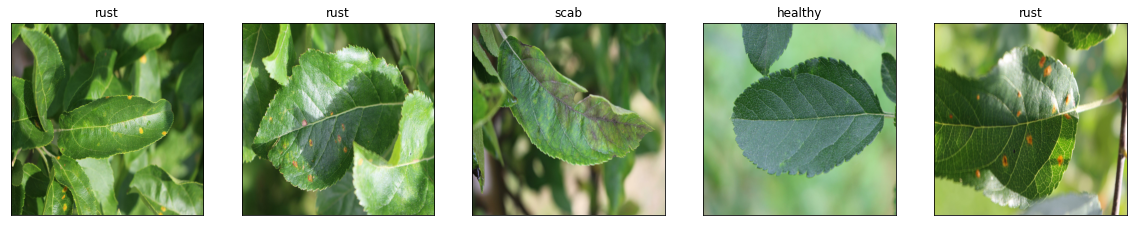

In [34]:
dic = dict([(0,'healthy'),(2,"rust"),(3,"scab"),(1,"multiple disease")])
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = i
    plt.imshow(test_images[image_ind])
    key = prediction[image_ind]
    plt.title(dic[key])

It is! Note that "healthy" leaf are green; "scab" leaf has brown marks on it which indicate bactaria/fungal infection; "rust" leaf which has yellow mark on it, which indicate a specific kind of rust fungi

## 1.5 Conclusion

In this mini project, we transfer and leverage the pretrained image recognition model -- DenseNet121 and apply it to our CNN to maximize training accuracy. We also find the importance role of changing learning rate plays, in order to obtain stable validating data accuacy when training CNN model.